In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.decomposition import TruncatedSVD
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from umap.umap_ import UMAP
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import os
import scanpy as sc

import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import mse


c:\Users\jakob\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata = sc.read_h5ad("mouse_diabetes.h5ad", backed='r')

# Access obs (cell metadata) - this is fully loaded into memory
obs_df = adata.obs.copy()
obs_df = obs_df[~obs_df['cell_type'].isin(['unknown', 'cell'])]

# Determine total samples
total_sample_size = 20000
np.random.seed(42)


# Optional: check your metadata structure
# print(obs_df['cell_type'].value_counts())
# print(obs_df['disease_type'].value_counts())

# Create a combined stratification column if you want to conserve both cell type and disease type
obs_df['strata'] = obs_df['cell_type'].astype(str) + "_" + obs_df['disease'].astype(str)

# Sample size per strata proportional to their representation
strata_counts = obs_df['strata'].value_counts()
strata_sample_sizes = (strata_counts / strata_counts.sum() * total_sample_size).round().astype(int)

# Perform sampling per strata
sampled_indices = []
for strata_value, sample_size in strata_sample_sizes.items():
    strata_indices = obs_df[obs_df['strata'] == strata_value].index
    if len(strata_indices) < sample_size:
        sample_size = len(strata_indices)  # avoid over-sampling
    sampled_indices.extend(np.random.choice(strata_indices, sample_size, replace=False))

# Now, create a new AnnData with only these samples
adata_sampled = adata[sampled_indices].to_memory()

sc.pp.log1p(adata_sampled)

In [3]:
disease_types = adata_sampled.obs['disease'].unique()

# Create a dictionary to hold disease-specific arrays
disease_arrays = {}

for disease in disease_types:
    subset = adata_sampled[adata_sampled.obs['disease'] == disease]
    
    # Convert X to dense array if needed
    X_array = subset.X.toarray() if not isinstance(subset.X, np.ndarray) else subset.X
    
    disease_arrays[disease] = X_array
    
    print(f"{disease}: shape {X_array.shape}")

combined_data_normal = disease_arrays['normal']
combined_data_endocrine = disease_arrays['endocrine pancreas disorder']
combined_data_type1 = disease_arrays['type 1 diabetes mellitus']
combined_data_type2 = disease_arrays['type 2 diabetes mellitus']

normal: shape (7401, 31202)
type 2 diabetes mellitus: shape (7511, 31202)
type 1 diabetes mellitus: shape (3022, 31202)
endocrine pancreas disorder: shape (2066, 31202)


In [4]:

X = adata_sampled.X.toarray()

pca = PCA(n_components=50, random_state=42)
combined_data_normal_reduced = pca.fit_transform(combined_data_normal)
adata_reduced = pca.transform(X)

scaler = MaxAbsScaler()
combined_data_normal_scaled = scaler.fit_transform(combined_data_normal_reduced)
adata_scaled = scaler.transform(adata_reduced)

c:\Users\jakob\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


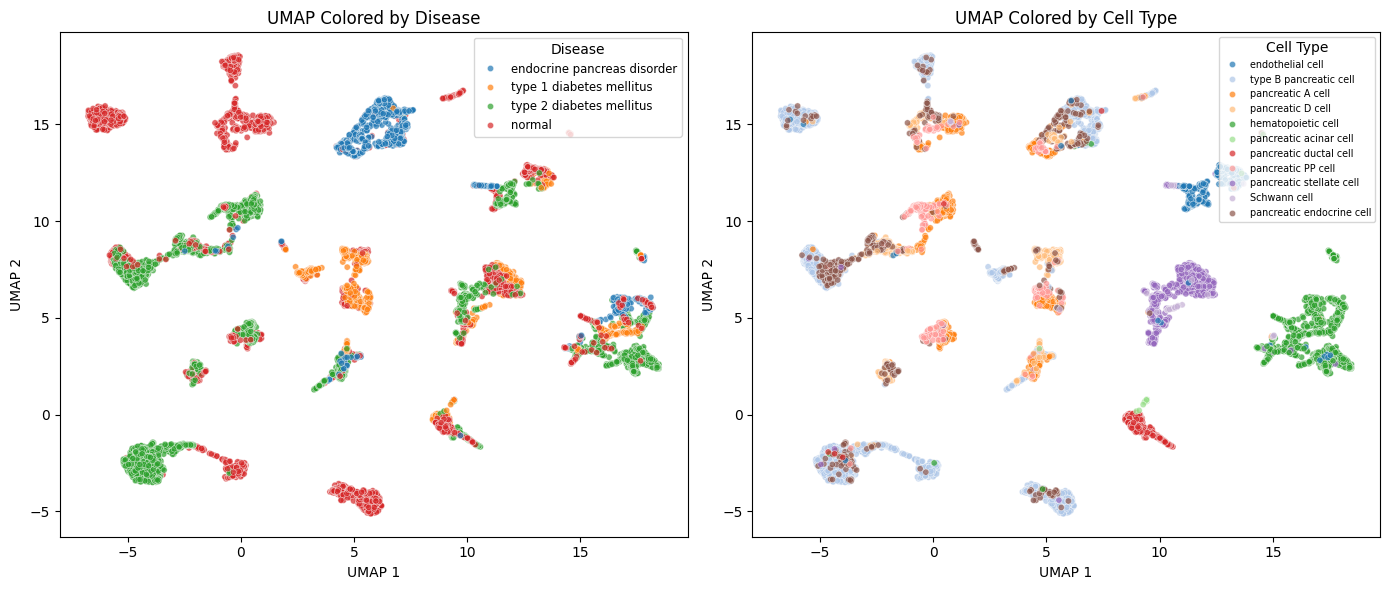

In [5]:
# Get labels
disease_labels = adata_sampled.obs['disease'].values
cell_type_labels = adata_sampled.obs['cell_type'].values

# Run UMAP on SVD-reduced data
umap_model = umap.UMAP(random_state=42)
umap_embedding = umap_model.fit_transform(adata_scaled)

# Create figure with 1x2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=100)

# First subplot: colored by disease
sns.scatterplot(
    x=umap_embedding[:, 0], y=umap_embedding[:, 1],
    hue=disease_labels,
    palette='tab10',
    alpha=0.7, s=20,
    ax=axes[0], legend='full'
)
axes[0].set_title("UMAP Colored by Disease")
axes[0].set_xlabel("UMAP 1")
axes[0].set_ylabel("UMAP 2")
axes[0].legend(loc='best', fontsize='small', title='Disease')

# Second subplot: colored by cell type
sns.scatterplot(
    x=umap_embedding[:, 0], y=umap_embedding[:, 1],
    hue=cell_type_labels,
    palette='tab20',
    alpha=0.7, s=20,
    ax=axes[1], legend='full'
)
axes[1].set_title("UMAP Colored by Cell Type")
axes[1].set_xlabel("UMAP 1")
axes[1].set_ylabel("UMAP 2")
axes[1].legend(loc='best', fontsize='x-small', title='Cell Type')

plt.tight_layout()
plt.show()